# <span style="color:blue">Quant Final Project</span>
## Finance 372 - Prof Travis Johnson

## Solution by: <span style="color:orange">Trent Becker, Arjun Nair, Madhavan Uchani </span>

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
from pathlib import Path

In [2]:
df = pd.read_csv("crsp_finalproject.csv", dtype={'PERMNO': 'str', 'date': 'str', 'TICKER': 'str', 'COMNAM': 'str', 'PRC': 'float', 'VOL': 'float', 'RET': 'str', 'SHROUT': 'float'})
df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
df['RET'] = df['RET'].astype(float)
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '1985-12-31']
df['date'] = pd.to_datetime(df['date'])
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['year'] = pd.DatetimeIndex(df['date']).year

<ipython-input-2-e87dd28e0763>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Now remove unnecessary columns, keeping only gvkey, datadate, at, cogs, and revt. Write the edited dataframe into a .dta file using `.to_stata('gp_data.dta',write_index=False)`

Run this cell without editing it to show us what your signal_df looks like:

In [3]:
df

,PERMNO,date,TICKER,COMNAM,PRC,VOL,RET,SHROUT,month,day,year
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,12,31,1985
1,10000,1986-01-31,OMFGA,OPTIMUM MANUFACTURING INC,-4.37500,1771.0,NaN,3680.0,1,31,1986
2,10000,1986-02-28,OMFGA,OPTIMUM MANUFACTURING INC,-3.25000,828.0,-0.257143,3680.0,2,28,1986
3,10000,1986-03-31,OMFGA,OPTIMUM MANUFACTURING INC,-4.43750,1078.0,0.365385,3680.0,3,31,1986
4,10000,1986-04-30,OMFGA,OPTIMUM MANUFACTURING INC,-4.00000,957.0,-0.098592,3793.0,4,30,1986
...,...,...,...,...,...,...,...,...,...,...,...
4325383,93436,2022-08-31,TSLA,TESLA INC,275.60999,7322218.0,-0.072489,3133470.0,8,31,2022
4325384,93436,2022-09-30,TSLA,TESLA INC,265.25000,12965500.0,-0.037589,3158000.0,9,30,2022
4325385,93436,2022-10-31,TSLA,TESLA INC,227.53999,17325849.0,-0.142168,3157752.0,10,31,2022
4325386,93436,2022-11-30,TSLA,TESLA INC,194.70000,18824244.0,-0.144326,3157752.0,11,30,2022


Copy and modify the BMDataProcessor to create a GPDataProcessor class. It should load the same `price_df` as before (from the monthly_returns.csv file) but a new `signal_df` with revt, cogs, and lag_at columns (in addition to the date and security_id columns). The lag_at column should contain the prior year's at value, which you can get using the included  `safe_lead_lag` method

Let's be very conservative and say we can't rely on having accounting data until 120 days after the end of the fiscal year ('datadate' column). Assume we are willing to use accounting data up to two years old.

***HINT***: be sure to change the `data_folder_path`, `min_accounting_lag`, `max_accounting_lag`, and the constructor `__init__(self)` to reflect the new strategy. The `unique_dates()` and `signal_df_for_date` functions only need to be updated to use datatdate instead of rdq (since we don't have an rdq column in this annual data). These functions will otherwise work as-is, and the other functions don't need to be changed at all.

In [20]:
# Solution
# Define class here
class IRDataProcessor():
    
    # Path to where we store the data
    data_folder_path = Path('') 
    
    # Minimum share price to open a new position
    min_share_price = 5.0
    
    # Constructor, loads/cleans/merges data as needed
    def __init__(self):
        
        # Load price data: monthly 1961-2020 sample from CRSP including all public US equities
        # In monthly_returns.csv
        self.price_df = pd.read_csv(self.data_folder_path / 'monthly_prices.csv', dtype={'PERMNO': 'str', 'date': 'str', 'TICKER': 'str', 'PRC': 'float', 'VOL': 'float', 'RET': 'str', 'SHROUT': 'float'})
        self.price_df['RET'] = pd.to_numeric(self.price_df['RET'], errors='coerce')
        self.price_df['RET'] = self.price_df['RET'].astype(float)
        self.price_df = self.price_df.dropna()       
        
        # Parse the yyyyMMdd int dates into DateTime64
        # Based on formatting strings here
        # https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
        self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'])
        self.price_df['month'] = pd.DatetimeIndex(self.price_df['date']).month
        self.price_df['year'] = pd.DatetimeIndex(self.price_df['date']).year
        # Prices sometimes negative to indicate no volume at closing auction
        # In these cases, price = -0.5*(bid+ask)
        # But we don't use that information and so want prices to always be positive
        # See http://www.crsp.org/products/documentation/data-definitions-p
        self.price_df.loc[:,'PRC'] = np.absolute(self.price_df.loc[:,'PRC'])
        
        # Add next-months return as a new column 'ret_next'
        # Use the safe_lead_lag: want lead return but only when permno the same
        self.price_df.loc[:,'ret_next'] = safe_lead_lag(self.price_df.loc[:,'RET'],self.price_df.loc[:,'PERMNO'],1)
        
        # Load accounting data used for BM signal
        # Annual sample from 1961-2020 from Compustat Fundamentals Annual
        # Stored in the `annual_accounting.dta` file
        # `.dta` files are Stata data, and do a better job than `.csv` files of remembering data types
        # self.signal_df = pd.read_stata(self.data_folder_path / 'annual_accounting.dta')

        self.signal_df = pd.read_csv("crsp_finalproject.csv", dtype={'PERMNO': 'str', 'date': 'str', 'TICKER': 'str', 'COMNAM': 'str', 'PRC': 'float', 'VOL': 'float', 'RET': 'str', 'SHROUT': 'float'})
        # self.signal_df.loc[:,'date'] = pd.to_datetime(self.signal_df.loc[:,'date'])
        self.signal_df = self.signal_df[self.signal_df['date'] >= '1985-12-31']
        self.signal_df['RET'] = pd.to_numeric(self.signal_df['RET'], errors='coerce')
        self.signal_df['RET'] = self.signal_df['RET'].astype(float)        

        # Add the lag_at column as the prior year's 'at' value
        # self.signal_df.loc[:,'lag_at'] = safe_lead_lag(self.signal_df.loc[:,'at'],self.signal_df.loc[:,'gvkey'],-1)
        self.signal_df['date'] = pd.to_datetime(self.signal_df['date'])
        self.signal_df['month'] = pd.DatetimeIndex(self.signal_df['date']).month
        self.signal_df['day'] = pd.DatetimeIndex(self.signal_df['date']).day
        self.signal_df['year'] = pd.DatetimeIndex(self.signal_df['date']).year
        self.signal_df.loc[self.signal_df['month'] == 4, "day"] = 30
        self.signal_df.loc[self.signal_df['month'] == 6, "day"] = 30
        
        import calendar
        self.signal_df['date'] = self.signal_df['date'].apply(lambda dt: dt.replace(day=calendar.monthrange(dt.year, dt.month)[1]))
        self.signal_df['PRC'] = self.signal_df['PRC'].abs()
        self.signal_df['market_cap'] = self.signal_df['PRC'] * self.signal_df['SHROUT']
        self.signal_df = self.signal_df.dropna()
        # The problem with our accounting data is that it identifies stocks using gvkey instead of permno
        # To merge with return_df, we need to use another dataset that converts gvkey to permno
        # This is stored in the gvkey_permno_conversion.dta file
        # self.gvkey_permno_conversion = pd.read_stata(self.data_folder_path / 'gvkey_permno_conversion.dta')

        prediction_date = '04/30'
        last_rebalance = '06/30'
        self.signal_df = self.liquidity_filter(self.signal_df)
        self.prediction_date = dt.datetime.strptime(prediction_date, '%m/%d')
        self.last_rebalance = dt.datetime.strptime(last_rebalance, '%m/%d')
        # Use a merge command to add the permno column to our signal_df
        # self.signal_df = self.signal_df.merge(self.gvkey_permno_conversion,on=['gvkey','datadate'])           
        
    # Returns an array with the unique dates for which we have loaded data
    # Uses from the price_df since that's how frequency we can update portfolio value
    # Filters all dates in price_df to return only dates for which we have signals as well
    def unique_dates(self):
        # price_dates = pd.Series( np.sort(self.price_df.loc[:,'date'].unique()) )
        # min_signal_date = self.signal_df.loc[:,'datadate'].min() + np.timedelta64(self.min_accounting_lag,'D')
        # max_signal_date =  self.signal_df.loc[:,'datadate'].max() + np.timedelta64(self.max_accounting_lag,'D')
        # return price_dates[ (price_dates >= min_signal_date) & (price_dates <= max_signal_date) ].array
        price_dates = pd.Series( np.sort(self.signal_df.loc[:,'date'].unique()) )
        return price_dates    
    # Returns a DataFrame containing one row for all securities in price_df as of date.
    # Columns must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - 'prc': price on date
    # - 'ret': return from previous date to date
    # Ignores liquidity and future-return availability requirements
    # To be used only for closing decisions and execution decisions
    # Some of the returned stocks cannot be traded
    def price_df_for_date(self,month,year):
        price_date_df = self.price_df.loc[ self.price_df.loc[:,'month'] == month, :]
        price_date_df = price_date_df.loc[ price_date_df.loc[:, 'year'] == year, :]
        return price_date_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}) 
    
    # Returns a DataFrame where each row is a security in the strategy's universe,
    # Columes must include:
    # - 'date': date on which price data observed
    # - 'security_id': a security identifier
    # - whatever signals the trading rule needs to decide which securities to open new positions in
    #   - In this case, return cshoq, prccq, and ceqq so trading rule can compute B/M ratio
    #
    # Also responsible for applying whatever liquidity filters are wanted to narrow universe,
    # and check that we have future return data (no point in backtesting if we don't know what happens next)
    def signal_df_for_date(self,date):
        # find set of permnos considered tradeable as of date 
                
        # start with all rows return_df on date with non-nan and non-infinite ret_next
        date_price_df = self.price_df.loc[ self.price_df.loc[:,'date'] == date,:]
        date_price_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}, inplace=True)  # use permno as our security_id        
        # date_price_df = date_price_df.loc[ np.isfinite(self.price_df.loc[:,'ret_next']),:]
        # date_price_df = date_price_df.drop(columns=['ret_next'])
        
        # now signal data
        # first only look at data announced at least accounting_lag_days prior to date
        # all_past_signal_df = self.signal_df.loc[(self.signal_df.loc[:,'datadate'] < date - np.timedelta64(self.min_accounting_lag,'D')),:]
        # then grab only the latest observation for each permno
        # latest_signal_df = all_past_signal_df.groupby('permno').last()
        
        # now merge with return data and return        
        # merged_df = date_price_df.merge(latest_signal_df,on='permno',how='inner')
        # merged_df = merged_df.rename(columns={'permno':'security_id'})  # use permno as our security_id
        
        # filter by liquidity requirements
        # merged_df = self.liquidity_filter(merged_df)
        
        # and return without the ret_next column so backtests don't cheat by using itz
        return date_price_df


    def filter_and_rank(self,df):
        #TODO commenting out for now because I think CRSP may only be US data and we could justify that but not sure
        # filtered_df = self.country_filter(self.signal_df)
        filtered_df = self.date_filter(df, self.prediction_date.month,self.last_rebalance.month)
        # filtered_df = filtered_df.loc[ np.isfinite(filtered_df.loc[:,'ret_next']),:]
        # filtered_df = filtered_df.drop(columns=['ret_next'])
  
        # TODO: May need to change this since dropping NaN gets rid of too many rows
        filtered_df = filtered_df[filtered_df['market_cap'].notna()]
        filtered_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}, inplace=True)  # use permno as our security_id        
        filtered_df = self.rank_by_market_cap(filtered_df)
        # ranking process
        return filtered_df


    # Returns a filterd version of the passed DataFrame,
    # with all observations deemed too illiquid removed
    # Liquidity requirements:
    #  - price >= $3

    def liquidity_filter(self,df):
        return df.loc[ df.loc[:,'PRC'] >= self.min_share_price,:]
      

    def date_filter(self, df, prediction_month, rebalance_month):
        condition1 = ((df['month'] == prediction_month))
        condition2 = ((df['month'] == rebalance_month))
        return df.loc[(condition1 | condition2),:]
  

    def rank_by_market_cap(self, df):
        df['rank'] = df.groupby(['date'])['market_cap'].rank(ascending=False, method='first')
        return df 
###################################################################
# Helper methods, do not modify
###################################################################

# Function safe_lead_lag returns a new Series with the lead/lagged values
#  but only when a group is the same for the lead/lag
# Inputs:
# - data_series: data we want to lead/lag
# - group_series: grouping we want to be the same for the lead/lag to be value
# requires data_series and group_series already by sorted by group_series
# so that all alike values of group_series are adjacent,
# meaning group_series should look like:
#    g_0
#    g_0
#    g_0
#    g_0
#    g_1
#    g_1
#    g_2
#    g_2 
#    ...
# where g_i indicates the observation is in group i,
# and once the first g_{i+1} appears no more g_i values appear
# 
# lead_lag > 0 returns a data_series with values of data_series lead_lag rows ahead
# as long as group_series remains the same, NaN if group different
# lead_lag < 0 returns a data_series with values of data_series -lead_lag rows behind 
# (same as lead_lag rows ahead) as long as group_series remains the same, NaN if group different
def safe_lead_lag(data_series,group_series,lead_lag): 
    df = pd.DataFrame({ 'data': data_series, 'group': group_series })
    return df.groupby(['group'])['data'].shift(-lead_lag)

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### Constructor tests: should print price_df and signal_df.

In [5]:
data_processor = IRDataProcessor()

print('data_processor.price_df:')
print(data_processor.price_df)

print('\n\n')
print('data_processor.signal_df:')
print(data_processor.signal_df)
print(data_processor.filter_and_rank(data_processor.signal_df))

<ipython-input-4-1a4207ecade5>:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'])


data_processor.price_df:
        PERMNO       date TICKER        PRC         VOL       RET     SHROUT  \
2        10000 1986-02-28  OMFGA    3.25000       828.0 -0.257143     3680.0   
3        10000 1986-03-31  OMFGA    4.43750      1078.0  0.365385     3680.0   
4        10000 1986-04-30  OMFGA    4.00000       957.0 -0.098592     3793.0   
5        10000 1986-05-30  OMFGA    3.10938      1074.0 -0.222656     3793.0   
6        10000 1986-06-30  OMFGA    3.09375      1069.0 -0.005025     3793.0   
...        ...        ...    ...        ...         ...       ...        ...   
3800157  93436 2022-08-31   TSLA  275.60999   7322218.0 -0.072489  3133470.0   
3800158  93436 2022-09-30   TSLA  265.25000  12965500.0 -0.037589  3158000.0   
3800159  93436 2022-10-31   TSLA  227.53999  17325849.0 -0.142168  3157752.0   
3800160  93436 2022-11-30   TSLA  194.70000  18824244.0 -0.144326  3157752.0   
3800161  93436 2022-12-30   TSLA  123.18000  29417041.0 -0.367334  3157752.0   

              

#### `ranking_df` test: should return DataFrame with market_cap field ranked by decreasing order on specific dates (4/30 and 6/30)

In [6]:
ranked_df = data_processor.filter_and_rank(data_processor.signal_df)
ranked_df

,security_id,date,TICKER,COMNAM,prc,VOL,ret,SHROUT,month,day,year,market_cap,rank
23,10001,1986-04-30,GFGC,GREAT FALLS GAS CO,6.37500,225.0,0.009901,985.0,4,30,1986,6.279375e+03,4404.0
25,10001,1986-06-30,GFGC,GREAT FALLS GAS CO,6.12500,238.0,-0.013069,985.0,6,30,1986,6.033125e+03,4496.0
35,10001,1987-04-30,GFGC,GREAT FALLS GAS CO,6.12500,188.0,-0.039216,991.0,4,30,1987,6.069875e+03,4789.0
37,10001,1987-06-30,GFGC,GREAT FALLS GAS CO,5.87500,146.0,0.051429,991.0,6,30,1987,5.822125e+03,4880.0
47,10001,1988-04-30,GFGC,GREAT FALLS GAS CO,6.31250,121.0,0.030612,992.0,4,30,1988,6.262000e+03,4472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4325357,93436,2020-06-30,TSLA,TESLA INC,1079.81006,2551787.0,0.293186,186000.0,6,30,2020,2.008447e+08,26.0
4325367,93436,2021-04-30,TSLA,TESLA INC,709.44000,6774422.0,0.062147,963330.0,4,30,2021,6.834248e+08,7.0
4325369,93436,2021-06-30,TSLA,TESLA INC,679.70001,5186813.0,0.087137,984003.0,6,30,2021,6.688268e+08,7.0
4325379,93436,2022-04-30,TSLA,TESLA INC,870.76001,5046142.0,-0.191945,1036010.0,4,30,2022,9.021161e+08,4.0


#### Try it for a specific date to prove values are sorted/ranked correctly.

In [7]:
# Prove it works for a specific date - look at 'rank' column
test_ranked_df = ranked_df.sort_values(by=['market_cap', 'date'], ascending = False)
test_ranked_df = test_ranked_df.loc[(test_ranked_df['date'] == '1998-06-30')]
test_ranked_df

,security_id,date,TICKER,COMNAM,prc,VOL,ret,SHROUT,month,day,year,market_cap,rank
255320,12060,1998-06-30,GE,GENERAL ELECTRIC CO,90.875,924414.0,0.089955,3258022.0,6,30,1998,2.960727e+08,1.0
14940,10107,1998-06-30,MSFT,MICROSOFT CORP,108.375,3106879.0,0.277819,2484636.0,6,30,1998,2.692724e+08,2.0
161620,11308,1998-06-30,KO,COCA COLA CO,85.500,699553.0,0.092823,2469341.0,6,30,1998,2.111287e+08,3.0
230220,11850,1998-06-30,XON,EXXON CORP,71.375,682701.0,0.012411,2446791.0,6,30,1998,1.746397e+08,4.0
934138,22752,1998-06-30,MRK,MERCK & CO INC,133.750,612706.0,0.147009,1195259.0,6,30,1998,1.598659e+08,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155059,81331,1998-06-30,WACLY,WACOAL CORP,51.000,37.0,0.017456,26.0,6,30,1998,1.326000e+03,6956.0
2434147,75343,1998-06-30,FAI,F A I INSURANCES LTD,5.750,380.0,-0.031579,189.0,6,30,1998,1.086750e+03,6957.0
3190671,81782,1998-06-30,TI,TELECOM ITALIA SPA,48.000,0.0,-0.092056,19.0,6,30,1998,9.120000e+02,6958.0
3292072,83336,1998-06-30,SCV,SCANIA AKTIEBOLAG,24.625,4.0,-0.017456,16.0,6,30,1998,3.940000e+02,6959.0


#### `unique_dates` test: should return array of unique dates

In [8]:
data_processor.unique_dates()

0     1985-12-31
1     1986-01-31
2     1986-02-28
3     1986-03-31
4     1986-04-30
         ...    
440   2022-08-31
441   2022-09-30
442   2022-10-31
443   2022-11-30
444   2022-12-31
Length: 445, dtype: datetime64[ns]

#### `price_df_for_date` test: should return DataFrame with all available observations on passed date

In [9]:
unique_dates = data_processor.unique_dates()
test_date = unique_dates[60]

test_price_df = data_processor.price_df_for_date(2, 1986)
test_price_df

,security_id,date,TICKER,prc,VOL,ret,SHROUT,RETX,month,year,ret_next
2,10000,1986-02-28,OMFGA,3.2500,828.0,-0.257143,3680.0,-0.257143,2,1986,0.365385
21,10001,1986-02-28,GFGC,6.2500,1067.0,0.020408,985.0,0.020408,2,1986,0.025200
402,10002,1986-02-28,MBNC,13.2500,1351.0,0.139785,1175.0,0.139785,2,1986,0.070755
729,10003,1986-02-28,GCBK,22.2500,4928.0,0.011364,1900.0,0.011364,2,1986,-0.011236
850,10005,1986-02-28,WERC,0.2500,147.0,-0.333333,4655.0,-0.333333,2,1986,0.125000
...,...,...,...,...,...,...,...,...,...,...,...
3780604,93252,1986-02-28,YUKN,3.3125,813.0,0.060000,4280.0,0.060000,2,1986,-0.056604
3783961,93279,1986-02-28,ZABS,2.1250,311.0,-0.227273,7589.0,-0.227273,2,1986,-0.147059
3784770,93287,1986-02-28,ZNTL,4.5000,4629.0,0.028571,7566.0,0.028571,2,1986,-0.125000
3787189,93308,1986-02-28,ZETA,6.3750,1344.0,0.186047,6000.0,0.186047,2,1986,NaN


#### `signal_df_for_date` test: should return DataFrame with most recent observations meeting liquidity requirements on passed date

In [10]:
test_signal_df = data_processor.signal_df_for_date(test_date)
test_signal_df

<ipython-input-4-1a4207ecade5>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_price_df.rename(columns={'PERMNO':'security_id', 'PRC': 'prc', 'RET': 'ret'}, inplace=True)  # use permno as our security_id


,security_id,date,TICKER,prc,VOL,ret,SHROUT,RETX,month,year,ret_next
79,10001,1990-12-31,GFGC,9.50000,106.0,0.001299,1054.0,-0.012987,12,1990,0.013158
460,10002,1990-12-31,MBNC,5.00000,225.0,-0.069767,1175.0,-0.069767,12,1990,-0.025000
787,10003,1990-12-31,GCBK,2.50000,1976.0,-0.230769,2194.0,-0.230769,12,1990,0.050000
908,10005,1990-12-31,WERC,0.04688,1272.0,0.000000,8347.0,0.000000,12,1990,0.666667
1125,10009,1990-12-31,IROQ,6.75000,116.0,0.038462,941.0,0.038462,12,1990,-0.018519
...,...,...,...,...,...,...,...,...,...,...,...
3771795,93156,1990-12-31,WHLS,20.50000,7243.0,0.012346,7856.0,0.012346,12,1990,0.067073
3778160,93220,1990-12-31,XLDC,6.50000,9283.0,-0.103448,11707.0,-0.103448,12,1990,0.269231
3779416,93236,1990-12-31,XYX,11.25000,2255.0,-0.174312,3221.0,-0.174312,12,1990,0.177778
3780662,93252,1990-12-31,YUKN,1.31250,682.0,-0.192308,4662.0,-0.192308,12,1990,0.047619


## Need to build our enter exit signals based on the market cap weights.
For Russell 2000: enter signal means market cap was outside of (1001-3000) and is now inside, exit signal means market cap was inside (1001-3000) and is now outside

In [21]:
def index_enter(df, trade_date):
    trade_date = pd.to_datetime(trade_date)
    rebalance_date =  trade_date - pd.DateOffset(years=1) + pd.DateOffset(months=2)
    future_date = trade_date + pd.DateOffset(years=1)
    wanted_dates = [trade_date, future_date,rebalance_date]
    df = df[df['date'].isin(wanted_dates)]

    last_rebalance_df = df.loc[df['date'] == rebalance_date]
    future_valid_names = list(df.loc[df['date'] == future_date]['security_id'])
    prediction_df = df.loc[df['date'] == trade_date]
    # Make sure we only check ones that we can potentially close on the future date
    prediction_df = prediction_df[prediction_df['security_id'].isin(future_valid_names)]
    # Filter last_rebalance_df by ones that are outside of 3000 ranking
    last_rebalance_names = list(last_rebalance_df[last_rebalance_df['rank'] > 3000]['security_id'])
    # Filter prediction_df by ones that are inside the 1001-3000 ranking
    prediction_df = prediction_df[(prediction_df['rank']>1000) & (prediction_df['rank']<3001)]
    prediction_df = prediction_df[prediction_df['security_id'].isin(last_rebalance_names)]
    
    # return prediction_df.nsmallest(20, 'rank')
    return prediction_df

def index_exit(df, trade_date): 
    trade_date = pd.to_datetime(trade_date)
    rebalance_date =  trade_date - pd.DateOffset(years=1) + pd.DateOffset(months=2)
    future_date = trade_date + pd.DateOffset(years=1)
    wanted_dates = [trade_date, future_date,rebalance_date]
    df = df[df['date'].isin(wanted_dates)]

    last_rebalance_df = df.loc[df['date'] == rebalance_date]
    future_valid_names = list(df.loc[df['date'] == future_date]['security_id'])
    prediction_df = df.loc[df['date'] == trade_date]
    # Make sure we only check ones that we can potentially close on the future date
    prediction_df = prediction_df[prediction_df['security_id'].isin(future_valid_names)]
    # Filter last_rebalance_df by ones that are inside of 1001-3000 ranking
    last_rebalance_names = list(last_rebalance_df[(last_rebalance_df['rank']>1000) & (last_rebalance_df['rank']<3001)]['security_id'])
    # Filter prediction_df by ones that are outside the 3000 ranking
    prediction_df = prediction_df[prediction_df['rank'] > 3000]
    prediction_df = prediction_df[prediction_df['security_id'].isin(last_rebalance_names)]
    
    # return prediction_df.nlargest(20, 'rank')
    return prediction_df

## Create a ProfTradingRule

This strategy should long stocks that are projected to enter the index and short stocks projected to exit the index, and use equal weighting

In [23]:
# Solution
class IRTradingRule():
    # strategy: always long top 10% by B/M and short bottom 10% by B/M, equal-weighted or value-weighted
    # For each $1 NAV, we open $1 total of long positions AND $1 total of short positions
    # This would be the max leverage allowed given 50% margin requirements
    #
    # Assume 100% of portfolio liquidated each month and repurchased with new quantities
    
    # strategy-specifc columns for trades_df (variables we want to keep track of for subsequent analysis)
    # usually the variables that led the strategy to open trade in the first place
    # In this case, just gross profitability ratio 'gp'
    strategy_specific_trades_df_columns = {'ir': pd.Series([], dtype='float')} 
    
    # minumum number of stocks with available ir for us to actually trade
    min_stocks_available = 5
    
    # value weighted?
    value_weighted = False
    
    def __init__(self,portfolio_db):
        self.portfolio_db = portfolio_db
    
    # Regardless of the strategy you are implementing, this method must return
    # open_trades_df, close_trades_df
    #
    # open_trades_df is a DataFrame with all the required trades_df columns plus any custom ones for this strategy
    #     each row is a new trade the strategy wants to open
    #     method only populates the security_id (index) and quantity required columns, plus any custom columns. Rest remain NaN to be populated elsewhere
    # close_trades_df is a DataFrame that is a subset of the rows of portfolio_db.trades_df
    #     each row is an exist trade the strategy wants to close
    #     we don't need to populate any columns in this function
    def compute_trades(self,signal_df, date):                
        # Since we are doing 100% turnover each period, all currently open trades should be closed
        close_trades_df = self.portfolio_db.trades_df.loc[ self.portfolio_db.trades_df.loc[:,'close_datetime'].isna() ,: ].copy()
        # print("CLOSE TRADES LENGTH: ", len(close_trades_df))
        # before deciding to open new positions, check that signal_df gives us a big enough set of stocks to actually do this
        if( len(signal_df) < self.min_stocks_available ):
            return self.empty_trades_df(), close_trades_df       
        
        # As our gross profitability measure, we'll use annual revenue (REVT), minus annual cost of goods sold (COGS), scaled by prior-year book value of assets (AT)        
        # signal_df.loc[:,'gp'] = (signal_df.loc[:,'revt'] - signal_df.loc[:, 'cogs']) / (signal_df.loc[:,'lag_at'])        
        # You shouldn't have to change anything below here if you are doing a decile strategy    
            
        # Find top 10% of signal column      
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        
        ## Can just switch these if want to try the reverse strategy
        buys_df = index_enter(signal_df, date)
        # Find bottom 10% of signal column
        # need to make a copy because we are going to modify this and don't want to affect signal_df
        sells_df = index_exit(signal_df, date)

        if( self.value_weighted ): 
            # Compute value weights
            buys_mktcap = buys_df.loc[:,'prc']*buys_df.loc[:,'shrout']
            buys_w = buys_mktcap / buys_mktcap.sum()
            sells_mktcap = sells_df.loc[:,'prc']*sells_df.loc[:,'shrout']
            sells_w = -sells_mktcap / sells_mktcap.sum() # weights negative because we are selling
            
            # Dollars per position equal total NAV * buys_w and NAV * sells_w, respectively
            buys_dollar = self.portfolio_db.current_nav() * buys_w
            buys_df.loc[:,'quantity'] = buys_dollar / buys_df.loc[:,'prc']
            sells_dollar = self.portfolio_db.current_nav() * sells_w
            sells_df.loc[:,'quantity'] = sells_dollar / sells_df.loc[:,'prc']             
                        
        else:
            # With equal weights we can go directly to dollars per buy/sell
            # Which is just NAV / number of positions
            dollars_per_buy = self.portfolio_db.current_nav() / len(buys_df)
            buys_df['quantity'] = dollars_per_buy / buys_df['prc']
      
            # figure out quantity per trade by splitting $ evenly
            dollars_per_sell = -self.portfolio_db.current_nav() / len(sells_df) # negative because we are selling
            sells_df['quantity'] = dollars_per_sell / sells_df['prc'] 
        
        # now make open_trades_df, keeping only security_id, quantity, and signal_col_name from the buys_df and sells_df
        
        # Append is going to be deprecated, so I'm relacing this
        # open_trades_df = self.empty_trades_df().append(
        #     buys_df.loc[:,['security_id','quantity',signal_col_name]]).append(
        #     sells_df.loc[:,['security_id','quantity',signal_col_name]]) 
        
        # With this
        # open_trades_df = pd.concat([self.empty_trades_df(), buys_df.loc[:,['security_id','quantity',signal_col_name]], sells_df.loc[:,['security_id','quantity',signal_col_name]] ])
        open_trades_df = self.empty_trades_df().append(
        buys_df.loc[:,['security_id','quantity']]).append(
        sells_df.loc[:,['security_id','quantity']])
        return open_trades_df, close_trades_df
    
    # Returns an empty trades_df
    # Used so we know the right columns to populate when creating a trades_df else
    def empty_trades_df(self):
        return pd.concat([self.portfolio_db.empty_trades_df(), pd.DataFrame(self.strategy_specific_trades_df_columns)], axis=1)
        

### After running your code above, you should be able to run these tests sucessfully. Please run each cell without editing.

#### `compute_trades` test: should output an open_trades_df with open positions having positive quantity and high gp, close_trades_df negative quantity and low gp, and an empty close_trades_df

In [13]:
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()
portfolio_db.add_cash(100)

data_processor = IRDataProcessor()
trading_rule = IRTradingRule(portfolio_db)

%run backtest_executor.ipynb
executor = BacktestExecutor(portfolio_db)
test_date = '1988-04-30'

test_price_df = data_processor.price_df_for_date(4, 1988)
test_signal_df = data_processor.filter_and_rank(data_processor.signal_df)
print(test_price_df)
test_open_trades_df, test_close_trades_df = trading_rule.compute_trades(test_signal_df, test_date)

<ipython-input-13-494a59d89da2>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.positions_df = self.positions_df.append(pd.DataFrame({'security_id':[self.cash_security_id],'quantity':[0], 'average_cost':[1], 'current_price':[1]}))
<ipython-input-4-1a4207ecade5>:24: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  self.price_df.loc[:,'date'] = pd.to_datetime(self.price_df.loc[:,'date'])


        security_id       date TICKER      prc      VOL       ret   SHROUT  \
47            10001 1988-04-29   GFGC   6.3125    121.0  0.030612    992.0   
428           10002 1988-04-29   MBNC   9.7500     32.0 -0.048780   1175.0   
755           10003 1988-04-29   GCBK  17.7500   1659.0 -0.089744   2194.0   
876           10005 1988-04-29   WERC   0.1250    243.0 -0.200000   8376.0   
1057          10008 1988-04-29   GACO  15.5000   1703.0  0.127273   2947.0   
...             ...        ...    ...      ...      ...       ...      ...   
3776216       93201 1988-04-29   WYSE  19.6250  39797.0  0.046667  14561.0   
3778128       93220 1988-04-29   XLDC  23.0000   5581.0  0.045455   6856.0   
3779384       93236 1988-04-29   XYYX   8.5000    823.0  0.214286   1519.0   
3780630       93252 1988-04-29   YUKN   1.9375    594.0 -0.088235   4279.0   
3787933       93316 1988-04-29   ZEUS   3.7500    664.0  0.034483   2669.0   

              RETX  month  year  ret_next  
47        0.030612 

<ipython-input-12-2c401bd8c0b1>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  open_trades_df = self.empty_trades_df().append(
<ipython-input-12-2c401bd8c0b1>:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  open_trades_df = self.empty_trades_df().append(


In [14]:
print('test_open_trades_df:')
print(test_open_trades_df)

print('\n\n')
print('test_close_trades_df:')
print(test_close_trades_df)

test_open_trades_df:
        security_id  quantity open_datetime  open_average_price  \
26176         10185  0.183824           NaT                 NaN   
56663         10414  0.178253           NaT                 NaN   
56758         10415  0.140056           NaT                 NaN   
59449         10441  0.280112           NaT                 NaN   
69358         10527  0.152788           NaT                 NaN   
...             ...       ...           ...                 ...   
4130901       91636 -0.053280           NaT                 NaN   
4135968       91679 -0.043290           NaT                 NaN   
4165800       91927 -0.052701           NaT                 NaN   
4223564       92479 -0.069264           NaT                 NaN   
4228832       92524 -0.085061           NaT                 NaN   

        close_datetime  close_average_price  ir  
26176              NaT                  NaN NaN  
56663              NaT                  NaN NaN  
56758              NaT  

## <span style="color:blue">Task 5</span>: Run the Backtest

If everything above was done correctly, the code in backtest.ipynb should produce a backtest for the gross profitability strategy with a few modifications.

Copy the backtest.ipynb code here and modify it as follows:
- Adjust the comments and strategy_info dictionary
- Do not run bm_data_processor.ipynb and bm_trading_rule.ipynb, as these are no longer needed (the GPDataProcessor and GPTradingRule classes should already be defined above)
- Replace the BM versions of data_processor and trading_rule with the GP versions. This should only be two lines of code

Nothing else should change.

In [24]:
# Solution
from IPython.display import display, Markdown, Latex, clear_output
import numpy as np
import pandas as pd

In [25]:
# # These tools should remain unchanged across strategies unless you have a good reason to change them
%run portfolio_db.ipynb
%run backtest_executor.ipynb # if you were live trading a strategy, this would be replace by code that submitted orders etc

In [26]:
# Step 2: Create the tools we'll need to do the backtest
# These can be customized and changed while keeping the rest of this file (the backtest logic) the same

# DO edit this code to make sure that the specifics tools you want for this backtest are chosen here

# DO NOT edit the names of the variables, only what's assigned to them. So 
# good: data_processor = MyNewDataProcessor() 
# bad: my_new_data_processor = MyNewDataProcessor()

# Data processor, in charge of loading and doling out data
data_processor = IRDataProcessor() 

In [27]:
# Portfolio database, keeps track of all the trades the backtest makes, the strategy NAV, and the current portfolio as we go through the backtest
%run portfolio_db.ipynb
portfolio_db = PortfolioDB()

# Strategy logic, in charge of choosing trades based on current portfolio and data
# This exact code would be used for live trading 
trading_rule = IRTradingRule(portfolio_db)

# Trade executor, in charge of "executing" trades the strategy decides on, turning them into transactions and updating the portfolio
trade_executor = BacktestExecutor(portfolio_db)

# Info about the strategy, used for ex-post statistics and output not the actual backtest
strategy_info = {
    'brief descriptor': 'ir_rebalancing', 
    'plot descriptor': 'Index Rebalancing Prediction Strategy, Equal-Weighted',
    'universe': 'Public US equities eligible for the Russell 2000',
    'signals': 'Change in market cap from prior year rebalance date (6/30) to current year prediction date (4/30)',
    'trading rule': 'Buy all equities entering 1001-3000 market cap and sell all equities exiting (as the predictor for inclusion/exclusion in Russell 2000), equal-weighted',
    'holding period': 'One year',
    'periods per year': 12,
    'output folder name': 'Output'
}

# Statistician, used to tabulate and plot statistics after the backtest runs
%run backtest_statistician.ipynb
statistican = BacktestStatistican(portfolio_db,strategy_info)

'1985-12-31: 100.0 | 0.0'

'1986-01-31: 100.0 | 0.0'

'1986-02-28: 100.0 | 0.0'

'1986-03-31: 100.0 | 0.0'

'1986-04-30: 100.0 | 0.0'

'1986-05-31: 100.0 | 0.0'

'1986-06-30: 100.0 | 0.0'

'1986-07-31: 100.0 | 0.0'

'1986-08-31: 100.0 | 0.0'

'1986-09-30: 100.0 | 0.0'

'1986-10-31: 100.0 | 0.0'

'1986-11-30: 100.0 | 0.0'

'1986-12-31: 100.0 | 0.0'

'1987-01-31: 100.0 | 0.0'

'1987-02-28: 100.0 | 0.0'

'1987-03-31: 100.0 | 0.0'

'1987-04-30: 100.0 | 100.0'

'1987-05-31: 96.45880861257268 | 98.81238265023538'

'1987-06-30: 93.13460522383107 | 100.12919094987285'

'1987-07-31: 94.17516513071905 | 102.8236315555045'

'1987-08-31: 92.4091437481384 | 105.78572171024805'

'1987-09-30: 91.67062016426316 | 105.04040828560701'

'1987-10-31: 91.53489295994544 | 75.29608553291209'

'1987-11-30: 92.13926993844241 | 72.39262152977005'

'1987-12-31: 92.5400343356984 | 75.48340092651577'

'1988-01-31: 89.58233553666639 | 79.84833380911482'

'1988-02-29: 89.2562607219514 | 85.1740967305499'

'1988-03-31: 88.76867808468914 | 89.73722618929628'

'1988-04-30: 89.38868590262284 | 89.38868590262283'

'1988-05-31: 91.55517094538723 | 86.82739658409426'

'1988-06-30: 88.92817627544876 | 92.71147595092063'

'1988-07-31: 90.51104955989474 | 92.24898997049544'

'1988-08-31: 90.82936937538099 | 90.7322047024009'

'1988-09-30: 92.70301727855924 | 92.67481289220459'

'1988-10-31: 90.02618898229751 | 93.05255104617427'

'1988-11-30: 91.93836977280112 | 90.35827497266234'

'1988-12-31: 90.15507723469211 | 92.88120754298822'

'1989-01-31: 87.30337543746671 | 98.73721950730581'

'1989-02-28: 86.06159935332524 | 99.3976091298295'

'1989-03-31: 85.09741738941948 | 102.14166334298017'

'1989-04-30: 84.90685535352559 | 84.90685535352559'

'1989-05-31: 87.5355141136864 | 87.80536685175026'

'1989-06-30: 85.07579866719061 | 88.7425001330234'

'1989-07-31: 86.80282748169778 | 94.8867239810106'

'1989-08-31: 87.01605314309714 | 97.23291451847716'

'1989-09-30: 91.8707545172227 | 97.89956818997901'

'1989-10-31: 92.76140779235912 | 93.3039141762866'

'1989-11-30: 92.7703365043783 | 93.89747209065366'

'1989-12-31: 93.71802619240368 | 95.18751047535811'

'1990-01-31: 85.79877422132913 | 89.33729659139549'

'1990-02-28: 88.56888466696405 | 91.46491916805611'

'1990-03-31: 90.23938350142052 | 94.35739618272628'

'1990-04-30: 88.82167767306814 | 88.82167767306812'

'1990-05-31: 89.67029601880398 | 94.26740443154823'

'1990-06-30: 94.2384553458208 | 94.71117489952572'

'1990-07-31: 97.97247996403138 | 90.43214661658847'

'1990-08-31: 96.79299777303049 | 78.51148513507493'

'1990-09-30: 100.32323273355735 | 70.50097289898034'

'1990-10-31: 103.3976088280968 | 65.51110589440957'

'1990-11-30: 101.4511445588484 | 70.48386224861552'

'1990-12-31: 104.17997410096845 | 72.36774384006958'

'1991-01-31: 103.14938722436348 | 78.60371264658671'

'1991-02-28: 104.6214840365111 | 87.64786426926288'

'1991-03-31: 104.62971208962239 | 94.23819487420936'

'1991-04-30: 102.54339883799848 | 102.5433988379985'

'1991-05-31: 103.42920106716196 | 106.82520435695352'

'1991-06-30: 101.18384439980625 | 102.86157522097298'

'1991-07-31: 107.84885440555608 | 107.27917306663423'

'1991-08-31: 112.42829448432346 | 110.61033788029857'

'1991-09-30: 115.99399466821221 | 112.60774426782007'

'1991-10-31: 123.83557783258624 | 116.2091873440412'

'1991-11-30: 120.45889064068102 | 112.21280605428441'

'1991-12-31: 127.49716610493726 | 120.17988017813312'

'1992-01-31: 119.73844439035233 | 131.56358933767004'

'1992-02-29: 114.48547465976095 | 135.5188831416402'

'1992-03-31: 107.30325502355156 | 132.0007772794887'

'1992-04-30: 101.08702226841939 | 101.08702226841936'

'1992-05-31: 103.65958107333746 | 104.1894379594842'

'1992-06-30: 99.02928000421309 | 98.32702588361809'

'1992-07-31: 101.13740118364626 | 101.41515642585631'

'1992-08-31: 97.0326667198122 | 98.4779889987303'

'1992-09-30: 99.98712589610287 | 101.2664327442539'

'1992-10-31: 105.19530212215602 | 104.8953367164963'

'1992-11-30: 110.2246045120258 | 112.4931633826699'

'1992-12-31: 107.34477588698509 | 114.84314504191818'

'1993-01-31: 104.99902044165653 | 119.0461891796115'

'1993-02-28: 99.80309422944566 | 116.05628074815445'

'1993-03-31: 100.56975648610239 | 121.90357879920276'

'1993-04-30: 92.55170308009419 | 92.55170308009423'

'1993-05-31: 92.3740599878517 | 96.12666962613335'

'1993-06-30: 94.81557215941476 | 95.86564677223234'

'1993-07-31: 94.5497923921734 | 97.02110986074157'

'1993-08-31: 98.39351911398253 | 100.94815397103008'

'1993-09-30: 103.11731077248412 | 104.8365895874046'

'1993-10-31: 100.6446386177441 | 108.81811023279778'

'1993-11-30: 95.00973602810308 | 104.68310420019031'

'1993-12-31: 95.71045358214913 | 107.92773406679885'

'1994-01-31: 91.47611507624475 | 112.59681392341005'

'1994-02-28: 90.79945188443294 | 110.6035558802551'

'1994-03-31: 86.82051545589928 | 102.99843089572119'

'1994-04-30: 90.90223302271679 | 90.9022330227168'

'1994-05-31: 87.81990956237388 | 90.49468307280252'

'1994-06-30: 85.39189493258142 | 87.25561985514851'

'1994-07-31: 87.91359286179804 | 88.67415703855211'

'1994-08-31: 90.13311563374452 | 93.11858431538714'

'1994-09-30: 91.47541969410295 | 93.92717344591524'

'1994-10-31: 93.78418026975405 | 94.57905750618634'

'1994-11-30: 91.4185059112615 | 92.02862292821986'

'1994-12-31: 92.64966860014907 | 91.98721170461185'

'1995-01-31: 88.78840561638101 | 93.03810481388682'

'1995-02-28: 89.78454027512294 | 96.3333492036311'

'1995-03-31: 91.76429302949776 | 99.50778336498378'

'1995-04-30: 91.86230342776041 | 91.8623034277604'

'1995-05-31: 91.74835090718913 | 93.89944524604635'

'1995-06-30: 96.79506975793149 | 99.66100237334402'

'1995-07-31: 102.08524348452812 | 105.70214955700183'

'1995-08-31: 101.9309548777527 | 106.16863394065822'

'1995-09-30: 103.74777839631989 | 108.0283895444301'

'1995-10-31: 101.4285822261597 | 102.11515849630243'

'1995-11-30: 103.11089751476098 | 105.51190938142551'

'1995-12-31: 102.93584772696396 | 106.00297400813005'

'1996-01-31: 99.0302440207944 | 107.15923167894346'

'1996-02-29: 102.86449840717003 | 109.24136717672161'

'1996-03-31: 102.48930771505925 | 110.70786480086636'

'1996-04-30: 105.51781105303985 | 105.51781105303985'

'1996-05-31: 109.51385696446663 | 111.3810513465329'

'1996-06-30: 109.21198061954817 | 106.9574949130145'

'1996-07-31: 100.93248365744904 | 97.03659939159712'

'1996-08-31: 105.98228351729028 | 102.46989538514373'

'1996-09-30: 111.32402051851732 | 107.4289464341532'

'1996-10-31: 106.80695327680198 | 106.09832445875963'

'1996-11-30: 105.12188679670092 | 109.83084159272522'

'1996-12-31: 104.8970569607776 | 112.30619855562244'

'1997-01-31: 103.5883591291132 | 116.4829479189284'

'1997-02-28: 96.3734826972948 | 111.44332276234138'

'1997-03-31: 93.32802308112412 | 105.23058834374893'

'1997-04-30: 91.61405645964716 | 91.61405645964717'

'1997-05-31: 86.27152338854413 | 104.58610852886889'

'1997-06-30: 90.56313665789858 | 110.35084281150225'

'1997-07-31: 93.6931382079659 | 115.4141705598322'

'1997-08-31: 92.13495714431862 | 119.39518935882103'

'1997-09-30: 94.08877956610226 | 128.0437023398164'

'1997-10-31: 93.05786732319567 | 120.93456656683273'

'1997-11-30: 94.8815884614213 | 118.57199688609737'

'1997-12-31: 101.73125427282852 | 117.30314784206877'

'1998-01-31: 98.41309264379737 | 116.71724226926224'

'1998-02-28: 94.30029873798325 | 126.21008023782656'

'1998-03-31: 89.96738606728762 | 132.2095275591854'

'1998-04-30: 88.19783310315113 | 88.19783310315113'

'1998-05-31: 89.20278976777774 | 83.05626970664031'

'1998-06-30: 97.6709179767369 | 84.42327442860112'

'1998-07-31: 97.70769189066546 | 79.25961687973104'

'1998-08-31: 93.94941120064553 | 62.19879261859758'

'1998-09-30: 96.67662863753544 | 67.54240178915488'

'1998-10-31: 95.44840617504727 | 70.97076131378799'

'1998-11-30: 99.19589952804014 | 77.35081187542092'

'1998-12-31: 105.08109843304409 | 81.0869823585693'

'1999-01-31: 109.25984480397496 | 86.38577805639311'

'1999-02-28: 107.54246672237414 | 80.78616447611331'

'1999-03-31: 112.30015590370975 | 84.0232341755182'

'1999-04-30: 114.09903572181872 | 114.09903572181875'

'1999-05-31: 110.06486811565885 | 117.7847072983921'

'1999-06-30: 119.40121740735965 | 125.75677886823951'

'1999-07-31: 116.6994885988525 | 125.37501663899201'

'1999-08-31: 120.33961522942681 | 121.14768130789133'

'1999-09-30: 123.97083771494701 | 121.93143751813801'

'1999-10-31: 131.55148686750823 | 120.84252130593248'

'1999-11-30: 135.96478341988467 | 131.11805227663905'

'1999-12-31: 143.29793455564447 | 147.9410649152597'

'2000-01-31: 137.21302071305843 | 152.01487982988223'

'2000-02-29: 164.87477559731988 | 184.71900825564816'

'2000-03-31: 145.43012201286234 | 174.800414465934'

'2000-04-30: 144.7641496951142 | 144.7641496951142'

'2000-05-31: 134.13097721456546 | 138.0784751216318'

'2000-06-30: 166.6818536505491 | 158.67752998871993'

'2000-07-31: 145.36231694472355 | 153.74886570361804'

'2000-08-31: 162.57554740003252 | 170.1709918510831'

'2000-09-30: 156.19357600207584 | 169.4600973916369'

'2000-10-31: 140.46593478307364 | 160.20291822356137'

'2000-11-30: 113.88840584474296 | 140.54836670535678'

'2000-12-31: 103.6615860457567 | 151.81104601081483'

'2001-01-31: 99.91493155676623 | 163.0043350410118'

'2001-02-28: 73.6733939618515 | 150.41034470668814'

'2001-03-31: 64.76466021268317 | 142.71145233078965'

'2001-04-30: 69.01280839444848 | 69.01280839444847'

'2001-05-31: 68.4345299569614 | 73.27491299690725'

'2001-06-30: 64.82129121590175 | 79.24554213632419'

'2001-07-31: 69.8243950462028 | 75.16870020403343'

'2001-08-31: 71.30515738888641 | 73.70374072724334'

'2001-09-30: 77.78892743966566 | 63.671631459317666'

'2001-10-31: 73.56861888912161 | 68.66145708848455'

'2001-11-30: 66.80628518908216 | 75.97762097507612'

'2001-12-31: 64.26593071139756 | 81.21142113755477'

'2002-01-31: 66.05109477054935 | 80.8775372660919'

'2002-02-28: 73.35465613338815 | 77.50858859255624'

'2002-03-31: 68.7843922884197 | 84.62329225278167'

'2002-04-30: 77.69096208937215 | 77.69096208937214'

'2002-05-31: 76.89909922706626 | 76.38044038550908'

'2002-06-30: 81.9150796628578 | 74.61697695940103'

'2002-07-31: 83.97050312733916 | 65.0424070429377'

'2002-08-31: 84.7016388658638 | 65.74094078910282'

'2002-09-30: 87.11693144007208 | 60.49011491074671'

'2002-10-31: 84.49732012542601 | 62.675687775741864'

'2002-11-30: 78.89361836584611 | 67.96657501597473'

'2002-12-31: 79.57818089539607 | 66.5470942733588'

'2003-01-31: 79.64136964948673 | 65.3868164256826'

'2003-02-28: 78.45397162702521 | 64.23658086873644'

'2003-03-31: 78.12269982099096 | 65.60716730311397'

'2003-04-30: 72.25393645089028 | 72.2539364508903'

'2003-05-31: 70.18991852267854 | 79.87239466656226'

'2003-06-30: 68.93544020450656 | 83.89712767705161'

'2003-07-31: 64.72686534388185 | 89.6331244914626'

'2003-08-31: 63.93730997924513 | 93.54147514855133'

'2003-09-30: 65.87917840202148 | 92.99889315890088'

'2003-10-31: 63.552868433614066 | 100.89366759225301'

'2003-11-30: 61.524513823009016 | 104.48786515091452'

'2003-12-31: 61.699854541582866 | 108.62105385452757'

'2004-01-31: 57.06870162702995 | 115.71810146499978'

'2004-02-29: 55.03650954909274 | 117.05680717445115'

'2004-03-31: 52.81344688095376 | 117.35676060632663'

'2004-04-30: 53.25117006088111 | 53.2511700608811'

'2004-05-31: 53.343152623731896 | 53.13092215285261'

'2004-06-30: 53.48499255421672 | 55.01458064402647'

'2004-07-31: 51.41498313272753 | 51.79645239670237'

'2004-08-31: 50.20951723580098 | 52.082226752341505'

'2004-09-30: 52.10261614901344 | 54.22496450082189'

'2004-10-31: 52.52440704958575 | 55.12426182832409'

'2004-11-30: 55.23162086442292 | 59.37552711338348'

'2004-12-31: 56.641992230827036 | 61.46851915657843'

'2005-01-31: 55.31697239297188 | 60.06342490491276'

'2005-02-28: 57.04050454246473 | 61.550214636496484'

'2005-03-31: 55.499454629355895 | 58.89016008859682'

'2005-04-30: 53.811791958124374 | 53.81179195812437'

'2005-05-31: 52.1346322609904 | 57.15927967832267'

'2005-06-30: 51.29319364683579 | 60.0397756405337'

'2005-07-31: 49.674386821604955 | 64.49758159539633'

'2005-08-31: 50.937107615238304 | 63.67472961963515'

'2005-09-30: 52.007085049014044 | 64.23404245740616'

'2005-10-31: 50.73835795966334 | 62.25587703160944'

'2005-11-30: 51.8745230150214 | 65.25317342892737'

'2005-12-31: 51.634566893822836 | 65.43929895297845'

'2006-01-31: 51.883923381653524 | 72.33285723905817'

'2006-02-28: 51.527732750076204 | 71.88971762123742'

'2006-03-31: 50.52517648794839 | 75.5712096795996'

'2006-04-30: 51.66356439819947 | 51.66356439819947'

'2006-05-31: 49.62897515563667 | 49.33519995131492'

'2006-06-30: 49.408754270529585 | 49.51446775501907'

'2006-07-31: 48.753453299450406 | 48.375573549176025'

'2006-08-31: 49.094979492393406 | 49.533036694287404'

'2006-09-30: 47.65959504048496 | 49.7288811967436'

'2006-10-31: 47.21559426374162 | 52.468873842147275'

'2006-11-30: 47.68251234159936 | 54.14597802112844'

'2006-12-31: 47.632489389623785 | 55.21018389667866'

'2007-01-31: 47.414491798339355 | 55.94951399246071'

'2007-02-28: 47.55915146836035 | 55.6543734159542'

'2007-03-31: 46.73437075242095 | 56.66135322736642'

'2007-04-30: 46.81186914116987 | 46.811869141169865'

'2007-05-31: 47.839401144484114 | 48.65772617427322'

'2007-06-30: 48.698555785085084 | 49.0364481410234'

'2007-07-31: 51.051663785831735 | 46.20223432423391'

'2007-08-31: 51.19550996971709 | 47.360279486169375'

'2007-09-30: 53.40183878917128 | 48.643602784428055'

'2007-10-31: 56.10373897876685 | 50.13422026524104'

'2007-11-30: 54.02161680853328 | 45.96794256201258'

'2007-12-31: 53.82898670943092 | 45.97880121142856'

'2008-01-31: 50.46929998483438 | 42.473947450579615'

'2008-02-29: 51.23891772866184 | 41.5348446166728'

'2008-03-31: 48.72776456692415 | 41.12906376752751'

'2008-04-30: 49.78616412661028 | 49.78616412661029'

'2008-05-31: 48.55536708234956 | 52.5047491904601'

'2008-06-30: 51.24296580627446 | 48.36778521554369'

'2008-07-31: 47.96406136829907 | 50.071350498113944'

'2008-08-31: 45.719742686372776 | 50.95609413681403'

'2008-09-30: 45.605083375994525 | 46.5435118863745'

'2008-10-31: 47.77707155875407 | 38.35737263951924'

'2008-11-30: 49.29635277600656 | 34.55414741956763'

'2008-12-31: 46.94338066390269 | 37.079227415798414'

'2009-01-31: 49.19448868390188 | 33.75423447634712'

'2009-02-28: 49.63685794539771 | 30.748236042286283'

'2009-03-31: 46.569841677370086 | 33.321084790529454'

'2009-04-30: 41.590958065475675 | 41.590958065475675'

'2009-05-31: 35.334830858917414 | 46.629796365893625'

'2009-06-30: 34.52684033800299 | 47.938249710234004'

'2009-07-31: 33.108266446038726 | 51.74780533301251'

'2009-08-31: 31.263880224552025 | 53.10731845917272'

'2009-09-30: 28.65404161238511 | 56.83416826485009'

'2009-10-31: 29.471568780538632 | 54.072379563641306'

'2009-11-30: 27.583009468276806 | 56.153214828852'

'2009-12-31: 25.448902795005168 | 59.90371692441053'

'2010-01-31: 28.00963706277158 | 57.336486860068106'

'2010-02-28: 27.078531930250694 | 59.21543840302911'

'2010-03-31: 23.456591720055208 | 64.20406874162177'

'2010-04-30: 22.152320539823585 | 22.152320539823585'

'2010-05-31: 21.66142187117032 | 20.470563082980952'

'2010-06-30: 21.324328102999637 | 19.624505561131464'

'2010-07-31: 21.628951687429673 | 20.742921283005003'

'2010-08-31: 21.387088549821453 | 19.656158664065906'

'2010-09-30: 21.747915601268428 | 21.45224646007047'

'2010-10-31: 22.22680731551349 | 22.479343377946073'

'2010-11-30: 22.236028570583983 | 22.782731594493136'

'2010-12-31: 22.97409077656408 | 24.369410732119952'

'2011-01-31: 23.09672019756004 | 23.73139828948937'

'2011-02-28: 23.734068311601405 | 24.89221086476939'

'2011-03-31: 23.10568244437566 | 25.12703975886147'

'2011-04-30: 23.23750007714668 | 23.237500077146677'

'2011-05-31: 22.398553357093476 | 22.75179274541815'

'2011-06-30: 22.092032593746794 | 22.27732644323585'

'2011-07-31: 22.158129106391556 | 21.856300056890774'

'2011-08-31: 21.29162141720122 | 20.32691841441052'

'2011-09-30: 19.119977763387404 | 18.51884111768733'

'2011-10-31: 20.75072167823288 | 20.475129032110694'

'2011-11-30: 20.447779662211918 | 20.31188416609501'

'2011-12-31: 19.792467129496313 | 20.30387784296374'

'2012-01-31: 20.19857865592605 | 21.672723922591466'

'2012-02-29: 20.43987673432088 | 22.087832995355974'

'2012-03-31: 20.434440677757685 | 22.300612283352265'

'2012-04-30: 20.48795711953368 | 20.487957119533675'

'2012-05-31: 21.257341703550466 | 19.10666488000574'

'2012-06-30: 21.0369821093631 | 20.02067968305684'

'2012-07-31: 21.555480557893762 | 20.10624323881773'

'2012-08-31: 21.320598856562338 | 20.693457159528183'

'2012-09-30: 21.18585914934248 | 21.49209145988861'

'2012-10-31: 21.810895918712273 | 20.81562755043929'

'2012-11-30: 21.731562344227804 | 21.055032295198263'

'2012-12-31: 20.92551144063154 | 21.808907646386327'

'2013-01-31: 20.65676100084217 | 22.942448118303655'

'2013-02-28: 21.25704977863603 | 22.954398151582627'

'2013-03-31: 21.555229485993838 | 23.746894915143702'

'2013-04-30: 21.75417742253647 | 21.754177422536465'

'2013-05-31: 21.29203306172885 | 22.01068458718271'

'2013-06-30: 21.258261175083494 | 21.835356019336494'

'2013-07-31: 21.661844676076555 | 23.08672510888934'

'2013-08-31: 21.555006866754375 | 22.554629107244033'

'2013-09-30: 21.59887240641559 | 24.154485392539492'

'2013-10-31: 21.265251428078855 | 24.646978896451536'

'2013-11-30: 21.559796263274706 | 25.445276652539114'

'2013-12-31: 21.833261489269347 | 25.927231238637418'

'2014-01-31: 22.10431367063651 | 25.213670902705253'

'2014-02-28: 22.12256315817813 | 26.24168298368376'

'2014-03-31: 21.44808023212838 | 26.551613818909274'

'2014-04-30: 21.057045274768072 | 21.057045274768072'

'2014-05-31: 21.128824817931044 | 21.178202571419174'

'2014-06-30: 21.59908904272173 | 22.125296301963424'

'2014-07-31: 21.338462016986497 | 21.150839768564257'

'2014-08-31: 21.8248204069622 | 22.045580307786985'

'2014-09-30: 21.90833717699711 | 21.05818401839098'

'2014-10-31: 21.707054856862445 | 22.016013612995295'

'2014-11-30: 21.843806618943432 | 22.21952148469112'

'2014-12-31: 21.13984439117625 | 22.365761983824505'

'2015-01-31: 20.97468330876231 | 21.821277757524648'

'2015-02-28: 21.50413312272101 | 22.877901006093545'

'2015-03-31: 21.945669978729548 | 23.09905055025275'

'2015-04-30: 22.17323148822504 | 22.17323148822503'

'2015-05-31: 22.92159157157238 | 22.61330131981219'

'2015-06-30: 22.95298553715579 | 22.823559759914307'

'2015-07-31: 23.981022789577246 | 22.21969814391264'

'2015-08-31: 23.14366222254816 | 20.929724871716022'

'2015-09-30: 23.436791779846207 | 19.784108481979462'

'2015-10-31: 23.489740951919465 | 21.17913462035086'

'2015-11-30: 23.53189088432928 | 21.91358422909551'

'2015-12-31: 24.109853356851563 | 20.999180901968334'

'2016-01-31: 23.833204024062216 | 18.726834469123535'

'2016-02-29: 23.436581301505193 | 18.730198237790933'

'2016-03-31: 23.026858087062912 | 20.268165264476462'

'2016-04-30: 22.664705414121983 | 22.664705414121983'

'2016-05-31: 22.431995030088363 | 22.79502681695083'

'2016-06-30: 22.988277405355692 | 22.927069720430495'

'2016-07-31: 22.34135102935793 | 24.016130717144428'

'2016-08-31: 21.307696495986296 | 24.522275022966284'

'2016-09-30: 20.444837942344 | 25.11954771162881'

'2016-10-31: 21.291486011226567 | 23.837369422975705'

'2016-11-30: 19.46160040337614 | 25.720569054531367'

'2016-12-31: 19.665505050010786 | 26.446810919429367'

'2017-01-31: 19.601750810348694 | 26.87329088190041'

'2017-02-28: 19.161594091046354 | 27.38988137150527'

'2017-03-31: 18.86350837020479 | 27.751369890888867'

'2017-04-30: 19.02687806242058 | 19.02687806242058'

'2017-05-31: 19.14639296138436 | 18.642728496870888'

'2017-06-30: 19.27784534831654 | 19.33585310206208'

'2017-07-31: 19.563740314699043 | 19.713418783210983'

'2017-08-31: 19.33313344970005 | 19.60696090337928'

'2017-09-30: 19.82707064887283 | 20.54492329686753'

'2017-10-31: 19.94556726580589 | 20.596927518017353'

'2017-11-30: 19.82871236952655 | 20.889696303174972'

'2017-12-31: 20.194136896515438 | 21.310921065097766'

'2018-01-31: 20.76800374754327 | 21.923705685363984'

'2018-02-28: 21.073109298323864 | 21.264737953000946'

'2018-03-31: 20.69689008421637 | 21.46475904241253'

'2018-04-30: 20.504936154322934 | 20.50493615432293'

'2018-05-31: 21.573433437003985 | 21.61459369887798'

'2018-06-30: 21.32745675859248 | 21.819943177554066'

'2018-07-31: 21.81356999760847 | 21.932302930088362'

'2018-08-31: 22.498587618122393 | 22.619850529625964'

'2018-09-30: 22.12864053426333 | 21.988046502660154'

'2018-10-31: 21.02021510948859 | 19.6184711345319'

'2018-11-30: 20.903542463652805 | 19.648333251054396'

'2018-12-31: 20.72161408846059 | 17.512785074889038'

'2019-01-31: 20.395197944421767 | 19.18576908956611'

'2019-02-28: 20.914195411500593 | 19.890268416029308'

'2019-03-31: 21.17369892705922 | 19.63709291317336'

'2019-04-30: 21.29273938333328 | 21.292739383333277'

'2019-05-31: 22.941448232017517 | 19.691501720034754'

'2019-06-30: 22.405744804719532 | 21.227407061444072'

'2019-07-31: 22.43277617989341 | 21.257821292189337'

'2019-08-31: 23.569506339000178 | 20.088767087813654'

'2019-09-30: 22.802379694432368 | 20.258567216114688'

'2019-10-31: 22.39228997119553 | 20.776078754404'

'2019-11-30: 22.665456272193513 | 21.83780117112565'

'2019-12-31: 22.2621934906833 | 22.776717178600403'

'2020-01-31: 23.96536736948837 | 22.15527685064242'

'2020-02-29: 24.791764604611092 | 20.814314060374308'

'2020-03-31: 24.569672755446078 | 16.55630574586537'

'2020-04-30: 24.091351982997526 | 24.091351982997516'

'2020-05-31: 24.522795495563535 | 25.758816247878705'

'2020-06-30: 24.1261705041157 | 27.120516618383796'

'2020-07-31: 25.45679081820345 | 27.53352338524217'

'2020-08-31: 24.25137880724862 | 29.259990445231637'

'2020-09-30: 25.653281661391347 | 27.644055729708583'

'2020-10-31: 25.495231143965547 | 27.44522209792266'

'2020-11-30: 22.044214054472445 | 33.54284280761961'

'2020-12-31: 21.798949410800393 | 35.842447149259534'

'2021-01-31: 22.919046432960286 | 38.50501802705023'

'2021-02-28: 19.55786902928029 | 41.76317302930679'

'2021-03-31: 15.60748695277147 | 42.48351058166323'

'2021-04-30: 16.422860566492265 | 16.422860566492268'

'2021-05-31: 16.673749167401894 | 16.79108790256241'

'2021-06-30: 17.29264357503116 | 17.257935180617842'

'2021-07-31: 16.822617834976604 | 16.719599099042185'

'2021-08-31: 16.726415497962325 | 16.90550166014161'

'2021-09-30: 16.60758680151582 | 16.445251701230518'

'2021-10-31: 17.101128851149227 | 17.11517381808183'

'2021-11-30: 17.1827490361741 | 16.73199560208988'

'2021-12-31: 16.438065968112042 | 16.781498618481656'

'2022-01-31: 15.450067130914906 | 15.55548046491394'

'2022-02-28: 15.633103575726098 | 15.58795791002528'

'2022-03-31: 15.565484851753634 | 15.818217177450427'

'2022-04-30: 14.855091307189607 | 0.0'

'2022-05-31: 14.855091307189607 | 0.0'

'2022-06-30: 14.855091307189607 | 0.0'

'2022-07-31: 14.855091307189607 | 0.0'

'2022-08-31: 14.855091307189607 | 0.0'

'2022-09-30: 14.855091307189607 | 0.0'

'2022-10-31: 14.855091307189607 | 0.0'

'2022-11-30: 14.855091307189607 | 0.0'

'2022-12-31: 14.855091307189607 | 0.0'

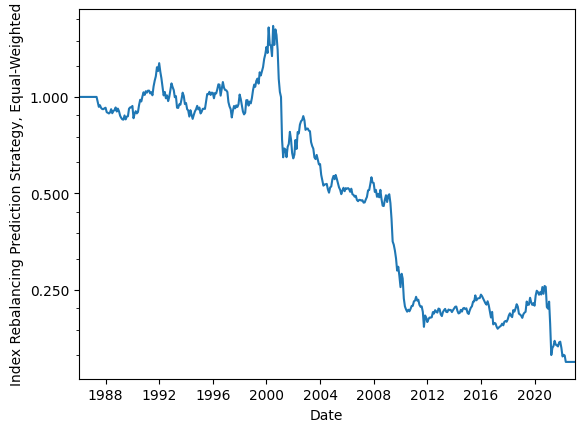

In [28]:
# Step 3: Run actual backtest
# Do NOT edit this cell without a very good reason
import warnings
warnings.filterwarnings("ignore")
# Add 100 initial cash to our portfolios
portfolio_db.add_cash(100)

# Get our list of unique dates
udates = data_processor.unique_dates()
# Main loop for the backtest
for date in udates:
    # dataframes for the date
    signal_df = data_processor.filter_and_rank(data_processor.signal_df)
    price_df = data_processor.price_df_for_date(date.month, date.year)
    # Update prices to reflect the new values after however much time has passed
    # Need to dot his first each date because the updated prices may affect our trading rule
    portfolio_db.update_prices(price_df)
    if date.month == 4:
    # Ask the trading rule what trades we should make
      open_trades_df, close_trades_df = trading_rule.compute_trades(signal_df=signal_df, date=date)
      # print('Reached', len(open_trades_df), len(close_trades_df))
        # price_df.to_csv('rand.csv')

      # apply dates to trades
      open_trades_df.loc[:,'open_datetime'] = date
      close_trades_df.loc[:,'close_datetime'] = date

      # execute trades
      trade_executor.execute_opens(open_trades_df=open_trades_df, price_df=price_df)
      trade_executor.execute_closes(close_trades_df=close_trades_df, price_df=price_df)    
    
    # Record account data for today
    portfolio_db.record_account_data(price_df=price_df,datetime=date)
    
    # Do some fancy output tracking our NAV and margin requirement each day
    # clear_output(wait=True)
    display( np.datetime_as_string(np.datetime64(date), unit='D') + ': ' + str(portfolio_db.current_nav()) + " | " + str(portfolio_db.current_margin()))
    
# Now that the loop is done, tell the statistican to output stats
statistican.output_stats()